In [130]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectFromModel
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest

In [2]:
random_state=42
cross_validation_folds = 5
n_jobs = 2
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
print('*'*40, "train")
print(train_df.info())
print('*'*40, 'test')
print(test_df.info())

**************************************** train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1

In [158]:
random_state=42
cross_validation_folds = 5
n_jobs = 2
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
test_ids = test_df.Id
y = train_df.SalePrice
train_df.drop(['SalePrice'], inplace=True, axis=1)
combine = [train_df, test_df]
combined = pd.concat([train_df, test_df])
train_df.replace(['NaN', 'NA', 'nan'], np.nan, inplace=True)
test_df.replace(['NaN', 'NA', 'nan'], np.nan, inplace=True)
def fill_column_with_median_value(df, column):
    """
    fill numerical columns with median value
    fill categorial columns with most common values
    """
    if df[column].dtype=='float64':
        median_value = combined[column][combined[column].notnull()].median()
    elif df[column].dtype=='object':
        median_value = combined[column][combined[column].notnull()].mode()[0]
    else:
        print('-- fuck --'* 40)
    df[column] = df[column].fillna(median_value)
def find_columns_with_na_values(df):
    for column in df.columns:
        if df.loc[df[column].isnull()].size>0:
            yield column

#finding good data
# empty_columns = []
# print("*** analyze train columns ***")
# for column in find_columns_with_na_values(train_df):
#     percent_empty = train_df.loc[train_df[column].isnull()].size * 100.0 / train_df.size
#     if percent_empty > 80:
#         empty_columns.append(column)
#     print(f"column = {column}, % empty value = {percent_empty}")

# print(f'all empty columns for train = {empty_columns}')
# empty_columns = []
# print("*** analyze test columns ***")
# for column in find_columns_with_na_values(test_df):
#     percent_empty = train_df.loc[train_df[column].isnull()].size * 100.0 / train_df.size
#     if percent_empty > 80:
#         empty_columns.append(column)
#     print(f"column = {column}, % empty value = {percent_empty}")
# print(f'all empty columns for test = {empty_columns}')

for dataset in combine:
    dataset.drop(['Id', 'Alley', 'PoolQC', 'MiscFeature', 'Fence'], inplace=True, axis=1)
    for column in find_columns_with_na_values(dataset):
        fill_column_with_median_value(dataset, column)
categorical_columns = list(filter(lambda col: train_df[col].dtype=='object', list(train_df.columns)))
mapping = dict()
# get the mapping between column labels to values
for column in categorical_columns:
    combined[column] = combined[column].astype('category')
    mapping[column] = dict(zip(combined[column].cat.categories, np.linspace(0, 1, len(combined[column].cat.categories))))
for dataset in combine:
    dataset.replace(mapping, inplace=True)
print(train_df.shape, test_df.shape)

#outliners removal
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_df)
y_noano = clf.predict(train_df)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
anomaly_indexes = y_noano[y_noano['Top'] == 1].index.values
train_df = train_df.iloc[anomaly_indexes]
train_df.reset_index(drop = True, inplace = True)
print(y.shape)
y = y.iloc[anomaly_indexes]
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train_df.shape[0])

combined = pd.concat([train_df, test_df])
scaler = MinMaxScaler()
scaler.fit(combined)
train = scaler.transform(train_df)
test = scaler.transform(test_df)
scaler_price = MinMaxScaler()
scaler_price.fit(y.as_matrix().reshape(-1, 1))
Y = scaler_price.transform(y.as_matrix().reshape(-1, 1))
print(train.shape, y.shape, test.shape)

(1460, 75) (1459, 75)
(1460,)
Number of Outliers: 146
Number of rows without outliers: 1314
(1314, 75) (1314,) (1459, 75)


/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [48]:
train

array([[0.23529412, 0.75      , 0.15068493, ..., 0.5       , 1.        ,
        0.8       ],
       [0.        , 0.75      , 0.20205479, ..., 0.25      , 1.        ,
        0.8       ],
       [0.23529412, 0.75      , 0.1609589 , ..., 0.5       , 1.        ,
        0.8       ],
       ...,
       [0.29411765, 0.75      , 0.15410959, ..., 1.        , 1.        ,
        0.8       ],
       [0.        , 0.75      , 0.1609589 , ..., 1.        , 1.        ,
        0.8       ],
       [0.        , 0.75      , 0.18493151, ..., 0.5       , 1.        ,
        0.8       ]])

## Define some helper functions for train/test split

In [149]:
seed = 2
np.random.seed(seed)

def train_test_score(model_fn, train, score_fn):
    scores = []
    kfold = KFold(n_splits=5, random_state=seed)
    for train_index, test_index in kfold.split(train):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        model = model_fn()
        model.fit(X_train, y_train)
        y_val = model.predict(X_test)
        score = score_fn(y_val, y_test)
        print(f'score = {score}')
        scores.append(score)
    scores = np.array(scores)
    print(f'resutls = {scores}')
    print("Results: mean=%f (std=%f) MSE" % (scores.mean(), scores.std()))
    

def predict_and_submit(model, test, file):
    y_pred = model.predict(test)
    Y_pred = scaler_price.inverse_transform(y_pred.reshape(-1, 1))
    submission = pd.DataFrame({
        "Id": test_ids,
        "SalePrice": Y_pred.reshape(-1)
    })
    submission.to_csv(file, index=False)

## Trying linear regression for baseline

In [165]:
print("*** MSE for linear regression ***")
train_test_score(LinearRegression, train, mean_squared_error)
print("*** R2 for linear regression ***")
train_test_score(LinearRegression, train, r2_score)

*** MSE for linear regression ***
score = 0.0027758226523013586
score = 0.002767285784978747
score = 0.0032418077623584457
score = 0.002143577820876677
score = 0.0024576267509740343
resutls = [0.00277582 0.00276729 0.00324181 0.00214358 0.00245763]
Results: mean=0.002677 (std=0.000366) MSE
*** R2 for linear regression ***
score = 0.8809451538851626
score = 0.8939858942778816
score = 0.8424101796525642
score = 0.8932513412116346
score = 0.8870730281384227
resutls = [0.88094515 0.89398589 0.84241018 0.89325134 0.88707303]
Results: mean=0.879533 (std=0.019152) MSE


In [160]:
model = LinearRegression()
model.fit(train, Y)
predict_and_submit(model, test, "house_price_result_linear_regression.csv")

In [161]:
! kaggle competitions submit house-prices-advanced-regression-techniques \
-f house_price_result_linear_regression.csv \
-m "baseline model with linear regression, with outliers removal"

Successfully submitted to House Prices: Advanced Regression Techniques

## Trying gradient boosting

In [164]:
print("*** MSE for gradient boosting ***")
train_test_score(GradientBoostingRegressor, train, mean_squared_error)
print("*** R2 for gradient boosting ***")
train_test_score(GradientBoostingRegressor, train, r2_score)

*** MSE for gradient boosting ***


/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score = 0.0023887628806859647
score = 0.002486427836892487
score = 0.0030261903454455613
score = 0.0020544413476487233
score = 0.002638807090846146
resutls = [0.00238876 0.00248643 0.00302619 0.00205444 0.00263881]
Results: mean=0.002519 (std=0.000318) MSE
*** R2 for gradient boosting ***
score = 0.8849611350033881
score = 0.9044162253089043
score = 0.8385856137917043
score = 0.8901837726850189
score = 0.8798484406721091
resutls = [0.88496114 0.90441623 0.83858561 0.89018377 0.87984844]
Results: mean=0.879599 (std=0.022085) MSE


In [162]:
model = GradientBoostingRegressor()
model.fit(train, Y)
predict_and_submit(model, test, "house_price_result_gradient_boosting.csv")

/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [163]:
! kaggle competitions submit house-prices-advanced-regression-techniques \
-f house_price_result_gradient_boosting.csv \
-m "baseline model with gradient boosting, with outliers removal"

Successfully submitted to House Prices: Advanced Regression Techniques

## Trying neural network

In [187]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(300, input_dim=75, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    opt_adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=opt_adam)
    return model
seed = 2
np.random.seed(seed)
scores = []
r2_scores = []
kfold = KFold(n_splits=5, random_state=seed)
for train_index, test_index in kfold.split(train):
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = baseline_model()
    model.fit(X_train, y_train, epochs=150, verbose=0)
    y_val = model.predict(X_test)
    score = mean_squared_error(y_val, y_test)
    r2_sc = r2_score(y_val, y_test)
    print(f'score = {score}, r2_score = {r2_sc}')
    scores.append(score)
    r2_scores.append(r2_sc)
scores = np.array(scores)
r2_scores = np.array(r2_scores)
print(f'resutls = {scores}, r2 results = {r2_scores}')
print("Results for mse: %f (%f)" % (scores.mean(), scores.std()))
print("Results for r2_score: %f (%f)" % (r2_scores.mean(), r2_scores.std()))

score = 0.0020034605703264153, r2_score = 0.9119408779862501
score = 0.0024272806622708063, r2_score = 0.9140818507231183
score = 0.002779601338704989, r2_score = 0.8605955212816977
score = 0.0018279765789179505, r2_score = 0.9056500760104182
score = 0.002299635006777903, r2_score = 0.8984459323199826
resutls = [0.00200346 0.00242728 0.0027796  0.00182798 0.00229964], r2 results = [0.91194088 0.91408185 0.86059552 0.90565008 0.89844593]
Results for mse: 0.002268 (0.000332)
Results for r2_score: 0.898143 (0.019548)


In [180]:
model = baseline_model()
model.fit(train, Y, epochs=150, verbose=1)

Epoch 1/150
1314/1314 [==============================] - 6s 5ms/step - loss: 0.1241
Epoch 2/150
1314/1314 [==============================] - 0s 259us/step - loss: 0.0836
Epoch 3/150
1314/1314 [==============================] - 0s 260us/step - loss: 0.0281
Epoch 4/150
1314/1314 [==============================] - 0s 262us/step - loss: 0.0216
Epoch 5/150
1314/1314 [==============================] - 0s 256us/step - loss: 0.0195
Epoch 6/150
1314/1314 [==============================] - 0s 259us/step - loss: 0.0167
Epoch 7/150
1314/1314 [==============================] - 0s 258us/step - loss: 0.0137
Epoch 8/150
1314/1314 [==============================] - 0s 257us/step - loss: 0.0107
Epoch 9/150
1314/1314 [==============================] - 0s 266us/step - loss: 0.0081
Epoch 10/150
1314/1314 [==============================] - 0s 266us/step - loss: 0.0064
Epoch 11/150
1314/1314 [==============================] - 0s 256us/step - loss: 0.0055
Epoch 12/150
1314/1314 [==============================

1314/1314 [==============================] - 0s 244us/step - loss: 0.0016
Epoch 96/150
1314/1314 [==============================] - 0s 216us/step - loss: 0.0016
Epoch 97/150
1314/1314 [==============================] - 0s 219us/step - loss: 0.0016
Epoch 98/150
1314/1314 [==============================] - 0s 246us/step - loss: 0.0016
Epoch 99/150
1314/1314 [==============================] - 0s 271us/step - loss: 0.0017
Epoch 100/150
1314/1314 [==============================] - 0s 284us/step - loss: 0.0016
Epoch 101/150
1314/1314 [==============================] - 0s 227us/step - loss: 0.0016
Epoch 102/150
1314/1314 [==============================] - 0s 226us/step - loss: 0.0016
Epoch 103/150
1314/1314 [==============================] - 0s 234us/step - loss: 0.0016
Epoch 104/150
1314/1314 [==============================] - 0s 218us/step - loss: 0.0016
Epoch 105/150
1314/1314 [==============================] - 0s 219us/step - loss: 0.0015
Epoch 106/150
1314/1314 [=========================

In [181]:
predict_and_submit(model, test, "house_price_result_neural_network_fix_outliners_bug_300_50_25_12.csv")

In [183]:
! kaggle competitions submit house-prices-advanced-regression-techniques \
-f house_price_result_neural_network_fix_outliners_bug_300_50_25_12.csv \
-m "baseline model with neural network. fixed error with outliners. increase the size of network to [300, 50, 25, 12]"

Successfully submitted to House Prices: Advanced Regression Techniques

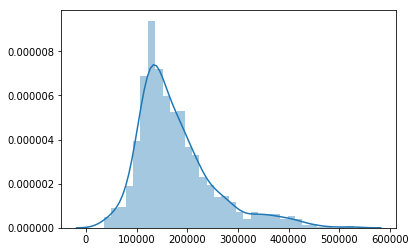

In [114]:
sns.distplot(Y_pred)

In [115]:
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": Y_pred.reshape(-1)
})
submission.to_csv('house_price_result_neural_network_150_epochs.csv', index=False)

In [116]:
! kaggle competitions submit house-prices-advanced-regression-techniques -f house_price_result_neural_network_150_epochs.csv \
-m "baseline model with neural network with new way of kfold, trained for 150 epochs"

Successfully submitted to House Prices: Advanced Regression Techniques

## Helper function to predict and submit

In [ ]:
def predict_and_submit(model, file, message):
    y_pred = model.predict(test)
    Y_pred = scaler_price.inverse_transform(y_pred.reshape(-1, 1))
    submission = pd.DataFrame({
        "Id": test_ids,
        "SalePrice": Y_pred.reshape(-1)
    })
    submission.to_csv(file, index=False)

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.1s finished


before reduced shape (1460, 75) (1459, 75)
** before reduced = [0.90379358 0.84615212 0.89467259 0.90070475 0.89222512]
reduced shape (1460, 22) (1459, 22)


/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.6s finished


** after reduced = [0.90893548 0.854222   0.89651126 0.89455615 0.89566519]


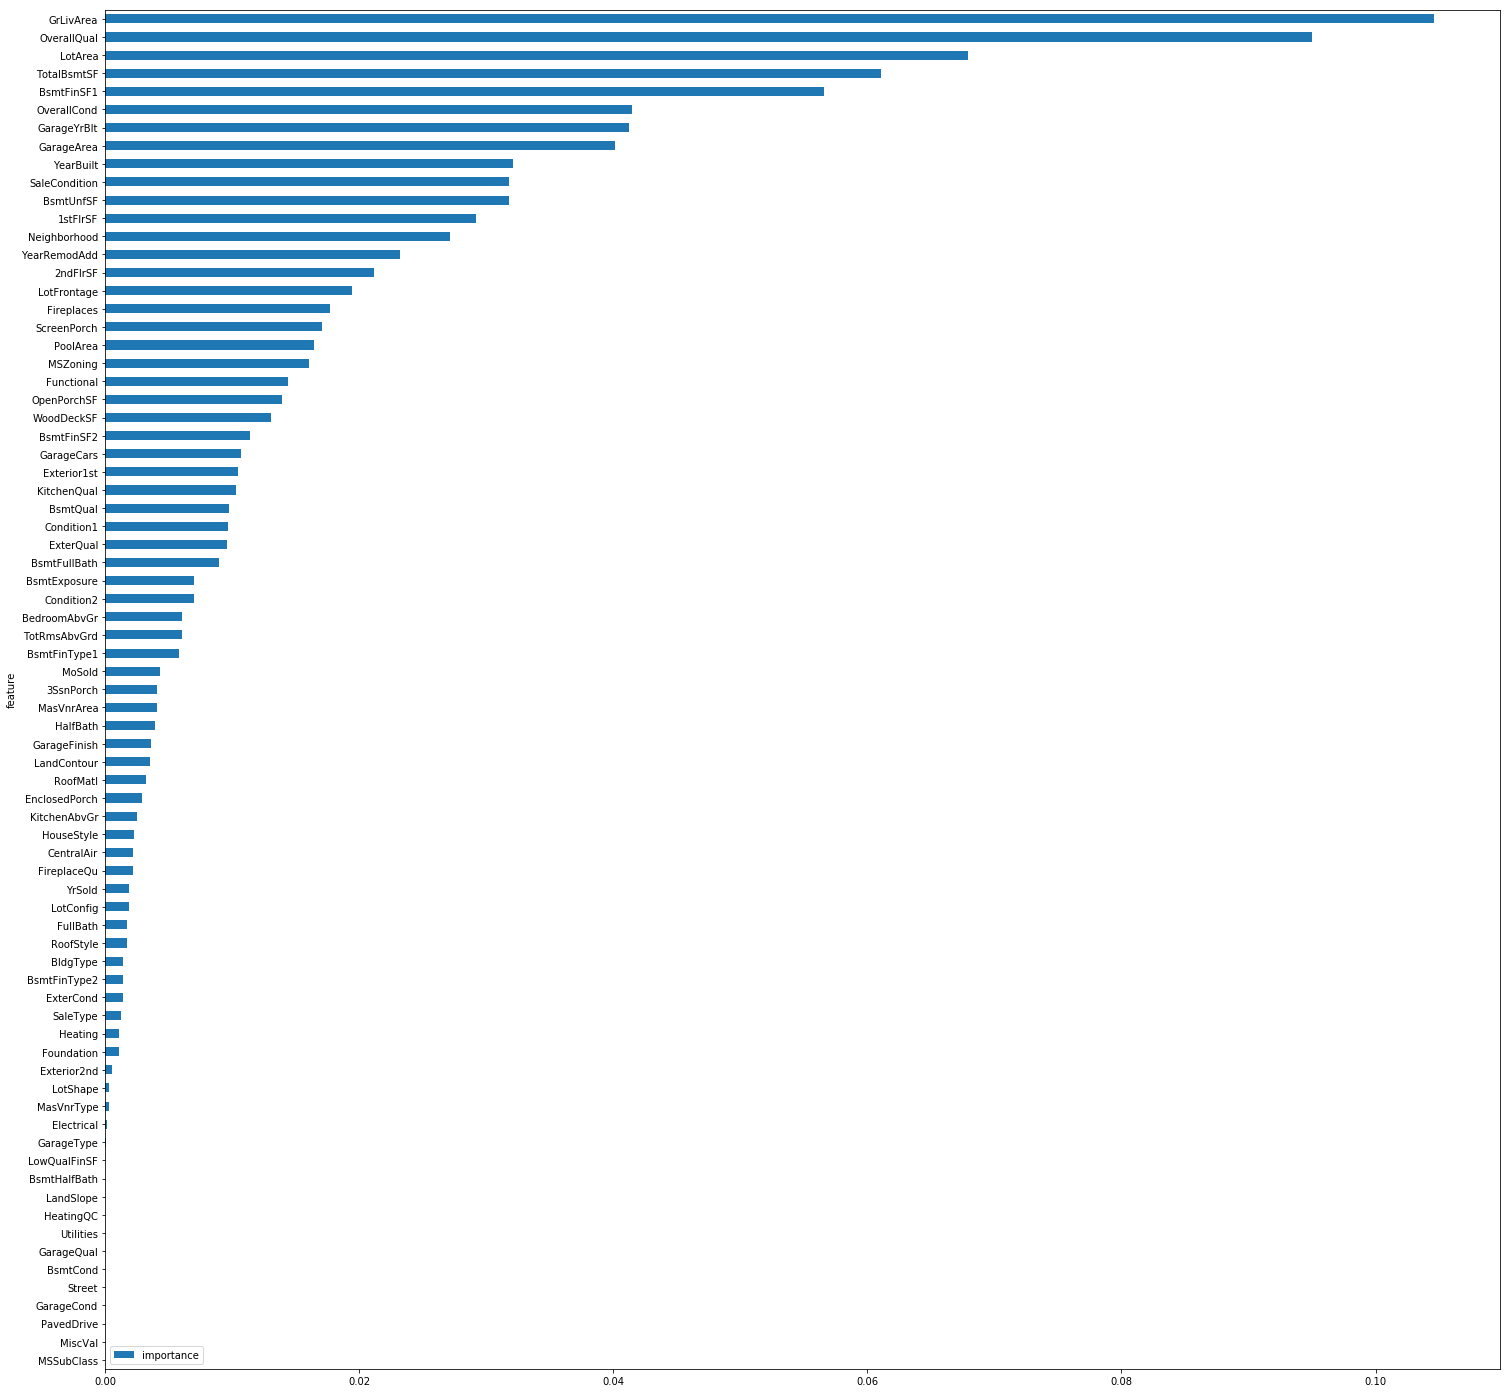

In [70]:
cv = cross_val_score(GradientBoostingRegressor(), train_df, y, cv=cross_validation_folds, n_jobs=n_jobs, verbose=1)
print(f"before reduced shape", train_df.shape, test_df.shape)
print(f"** before reduced = {cv}")
features = pd.DataFrame()
features['feature'] = train_df.columns
features['importance'] = rdf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(25, 25))
model = SelectFromModel(rdf, prefit=True)
train_reduced = model.transform(train_df)
test_reduced = model.transform(test_df)
print("reduced shape", train_reduced.shape, test_reduced.shape)
cv = cross_val_score(GradientBoostingRegressor(), train_reduced, y, cv=cross_validation_folds, n_jobs=n_jobs, verbose=1)
print(f"** after reduced = {cv}")

In [55]:
y_pred = rdf.predict(test_df)
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": y_pred
})
submission.to_csv('house_price_result_baseline_random_forest_all_nan_filled.csv', index=False)

In [56]:
! kaggle competitions submit house-prices-advanced-regression-techniques -f house_price_result_baseline_random_forest_all_nan_filled.csv \
-m "baseline model with gradient boosting, feature engineer and nan processed"

Successfully submitted to House Prices: Advanced Regression Techniques

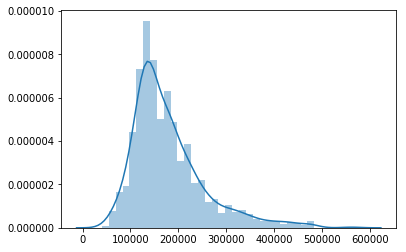

In [54]:
sns.distplot(y_pred)

## applying neural network